# Pre-trained models and transfer learning

Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

This approach is called **transfer learning**, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as **ImageNet**. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

## Cats vs. Dogs Dataset

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats), which can also be downloaded [from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (this process may take some time!):

In [3]:
# if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
#     !wget -P data https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

import os
import urllib.request

# Create data folder if it doesn't exist
os.makedirs("data", exist_ok=True)

url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
file_path = "data/kagglecatsanddogs_5340.zip"

if not os.path.exists(file_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, file_path)
    print("Download complete.")
else:
    print("File already exists.")

Download complete.


In [4]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

Unfortunately, there are some corrupt image files in the dataset. We need to do quick cleaning to check for corrupted files. In order not to clobber this tutorial, we moved the code to verify dataset into a module.

In [5]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image: data/PetImages/Cat\666.jpg
Corrupt image: data/PetImages/Dog\11702.jpg


c:\Users\sophi\.conda\envs\ai4beg\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Next, let's load the images into PyTorch dataset, converting them to tensors and doing some normalization. We will apply `std_normalize` transform to bring images to the range expected by pre-trained VGG network:

24998


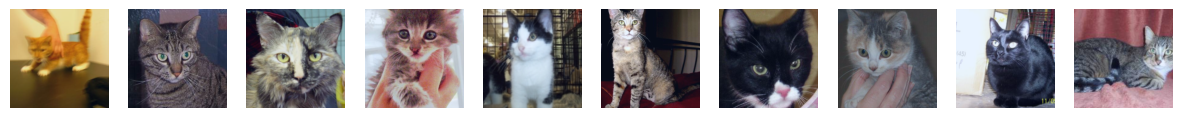

In [2]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize
])

dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset)
print(len(dataset))

## Pre-trained models

There are many different pre-trained models available inside `torchvision` module, and even more models can be found on the Internet. Let's see how simplest VGG-16 model can be loaded and used:

In [3]:
# vgg = torchvision.models.vgg16(pretrained=True)
# sample_image = dataset[0][0].unsqueeze(0)
# res = vgg(sample_image)
# print(res[0].argmax())

from torchvision.models import vgg16, VGG16_Weights

# loading model with new weights arguments
weights = VGG16_Weights.DEFAULT
vgg = vgg16(weights=weights)

sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax().item())


282


The result that we have received is a number of an `ImageNet` class, which can be looked up [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). We can use the following code to automatically load this class table and return the result:

In [4]:
import json, requests
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

Let's also see the architecture of the VGG-16 network:

In [5]:
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In addition to the layer we already know, there is also another layer type called **Dropout**. These layers act as **regularization** technique. Regularization makes slight modifications to the learning algorithm so the model generalizes better. During training, dropout layers discard some proportion (around 30%) of the neurons in the previous layer, and training happens without them. This helps to get the optimization process out of local minima, and to distribute decisive power between different neural paths, which improves overall stability of the network.

## GPU computations

Deep neural networks, such as VGG-16 and other more modern architectures require quite a lot of computational power to run. It makes sense to use GPU acceleration, if it is available. In order to do so, we need to explicitly move all tensors involved in the computation to GPU.

The way it is normally done is to check the availability of GPU in the code, and define `device` variable that points to the computational device - either GPU or CPU.


In [6]:
# PyTorch version
print("Torch version:", torch.__version__)

# CUDA availability
print("CUDA available:", torch.cuda.is_available())

# CUDA device name (if available)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

from PIL import Image

print(torch.__version__)
print(torchvision.__version__)
print(Image.__version__)

Torch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
2.5.1+cu121
0.20.1+cu121
11.3.0


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cuda


tensor(281, device='cuda:0')


## Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using `vgg.features` method:

torch.Size([1, 512, 7, 7])


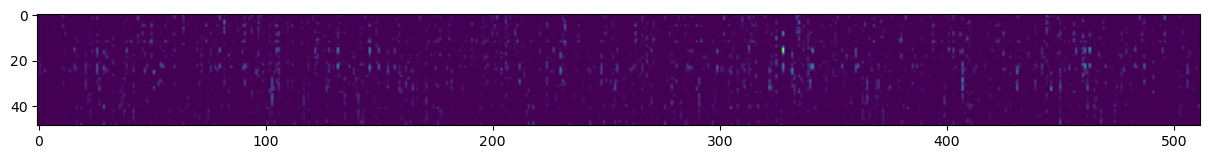

In [8]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(512,-1).T)
print(res.size())

The dimension of feature tensor is 512x7x7, but in order to visualize it we had to reshape it to 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called `feature_tensor`, and also labels into `label_tensor`:

In [9]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i >= num:
            break


....................................................................................................

Now we can define `vgg_dataset` that takes data from this tensor, split it into training and test sets using `random_split` function, and train a small one-layer dense classifier network on top of extracted features:

In [11]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(
    torch.nn.Linear(512*7*7,2),
    torch.nn.LogSoftmax(dim=1)
).to(device)

history = train(net,train_loader,test_loader)

Epoch  0, Train acc=0.930, Val acc=0.930, Train loss=0.025, Val loss=0.133
Epoch  1, Train acc=0.986, Val acc=0.970, Train loss=0.014, Val loss=0.077
Epoch  2, Train acc=0.973, Val acc=0.990, Train loss=0.035, Val loss=0.015
Epoch  3, Train acc=0.993, Val acc=0.990, Train loss=0.010, Val loss=0.002
Epoch  4, Train acc=0.999, Val acc=0.990, Train loss=0.003, Val loss=0.003
Epoch  5, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003
Epoch  6, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003
Epoch  7, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003
Epoch  8, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003
Epoch  9, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003


The result is great, we can distinguish between a cat and a dog with almost 98% probability! However, we have only tested this approach on a small subset of all images, because manual feature extraction seems to take a lot of time.

## Transfer learning using one VGG network

We can also avoid manually pre-computing the features by using the original VGG-16 network as a whole during training. Let's look at the VGG-16 object structure:

In [12]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

You can see that the network contains:
* feature extractor (`features`), comprised of a number of convolutional and pooling layers
* average pooling layer (`avgpool`)
* final `classifier`, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)

To train the end-to-end model that will classify our dataset, we need to:
* **replace the final classifier** with the one that will produce required number of classes. In our case, we can use one `Linear` layer with 25088 inputs and 2 output neurons.
* **freeze weights of convolutional feature extractor**, so that they are not trained. It is recommended to initially do this freezing, because otherwise untrained classifier layer can destroy the original pre-trained weights of convolutional extractor. Freezing weights can be accomplished by setting `requires_grad` property of all parameters to `False`

In [13]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

As you can see from the summary, this model contain around 15 million total parameters, but only 50k of them are trainable - those are the weights of classification layer. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

Now let's train the model using our original dataset. This process will take a long time, so we will use `train_long` function that will print some intermediate results without waiting for the end of epoch. It is highly recommended to run this training on GPU-enabled compute!

In [14]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.375, train loss = 0.055805571377277374
Epoch 0, minibatch 90: train acc = 0.9388736263736264, train loss = 0.139146972488571
Epoch 0, minibatch 180: train acc = 0.9544198895027625, train loss = 0.12179520116985174
Epoch 0, minibatch 270: train acc = 0.9603321033210332, train loss = 0.12883643118657748
Epoch 0, minibatch 360: train acc = 0.9634695290858726, train loss = 0.12803453355614827
Epoch 0, minibatch 450: train acc = 0.9649390243902439, train loss = 0.12965782148610727
Epoch 0, minibatch 540: train acc = 0.9664972273567468, train loss = 0.13761779164650964
Epoch 0, minibatch 630: train acc = 0.9687004754358162, train loss = 0.13534513252850758
Epoch 0, minibatch 720: train acc = 0.97000693481276, train loss = 0.13265389113088918
Epoch 0, minibatch 810: train acc = 0.970483970406905, train loss = 0.1316917692247948


c:\Users\sophi\.conda\envs\ai4begPyTorch\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 0, minibatch 900: train acc = 0.9716287458379578, train loss = 0.1299449484567928
Epoch 0, minibatch 990: train acc = 0.9730701311806257, train loss = 0.12759902907909468
Epoch 0, minibatch 1080: train acc = 0.973404255319149, train loss = 0.12736224687066375
Epoch 0, minibatch 1170: train acc = 0.9735269000853971, train loss = 0.13926544319758752
Epoch 0 done, validation acc = 0.974389755902361, validation loss = 0.22268270101009155


It looks like we have obtained reasonably accurate cats vs. dogs classifier! Let's save it for future use!

In [15]:
torch.save(vgg,'data/cats_dogs.pth')

We can then load the model from file at any time. You may find it useful in case the next experiment destroys the model - you would not have to re-start from scratch.

In [ ]:
vgg = torch.load('data/cats_dogs.pth')

# for future
# vgg = torchvision.models.vgg16(weights=None)  # define architecture
# vgg.load_state_dict(torch.load('data/cats_dogs.pth', weights_only=True))
# vgg.to(device)

C:\Users\sophi\AppData\Local\Temp\ipykernel_15464\549953597.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg = torch.load('data/cats_dogs.pth')


## Fine-tuning transfer learning

In the previous section, we have trained the final classifier layer to classify images in our own dataset. However, we did not re-train the feature extractor, and our model relied on the features that the model has learned on ImageNet data. If your objects visually differ from ordinary ImageNet images, this combination of features might not work best. Thus it makes sense to start training convolutional layers as well.

To do that, we can unfreeze the convolutional filter parameters that we have previously frozen. 

> **Note:** It is important that you freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If you immediately start training end-to-end network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.

In [17]:
for x in vgg.features.parameters():
    x.requires_grad = True

After unfreezing, we can do a few more epochs of training. You can also select lower learning rate, in order to minimize the impact on the pre-trained weights. However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching slightly higher level than in the case of fixed weights.

> **Note:** This training happens much slower, because we need to propagate gradients back through many layers of the network! You may want to watch the first few minibatches to see the tendency, and then stop the computation.

In [18]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

Epoch 0, minibatch 0: train acc = 1.0, train loss = 0.0
Epoch 0, minibatch 90: train acc = 0.9278846153846154, train loss = 0.23227213765238666
Epoch 0, minibatch 180: train acc = 0.930939226519337, train loss = 0.14843405412705563
Epoch 0, minibatch 270: train acc = 0.9391143911439115, train loss = 0.10652012842607674
Epoch 0, minibatch 360: train acc = 0.9437326869806094, train loss = 0.08475632812838145
Epoch 0, minibatch 450: train acc = 0.9490022172949002, train loss = 0.06979350663077276
Epoch 0, minibatch 540: train acc = 0.9506700554528651, train loss = 0.06012877430801251
Epoch 0, minibatch 630: train acc = 0.9531497622820919, train loss = 0.052854383804152014
Epoch 0, minibatch 720: train acc = 0.9539701803051318, train loss = 0.04776139067545347
Epoch 0, minibatch 810: train acc = 0.9553020961775586, train loss = 0.04361446394726322
Epoch 0, minibatch 900: train acc = 0.9567147613762487, train loss = 0.03990153864141839
Epoch 0, minibatch 990: train acc = 0.9567986881937437,

## Other computer vision models

VGG-16 is one of the simplest computer vision architectures. `torchvision` package provides many more pre-trained networks. The most frequently used ones among those are **ResNet** architectures, developed by Microsoft, and **Inception** by Google. For example, let's explore the architecture of the simplest ResNet-18 model (ResNet is a family of models with different depth, you can try experimenting with ResNet-151 if you want to see what a really deep model looks like):

In [19]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

As you can see, the model contains the same building blocks: feature extractor and final classifier (`fc`). This allows us to use this model in exactly the same manner as we have been using VGG-16 for transfer learning. You can try experimenting with the code above, using different ResNet models as the base model, and see how accuracy changes.

## Batch Normalization

This network contains yet another type of layer: **Batch Normalization**. The idea of batch normalization is to bring values that flow through the neural network to right interval. Usually neural networks work best when all values are in the range of [-1,1] or [0,1], and that is the reason that we scale/normalize our input data accordingly. However, during training of a deep network, it can happen that values get significantly out of this range, which makes training problematic. Batch normalization layer computes average and standard deviation for all values of the current minibatch, and uses them to normalize the signal before passing it through a neural network layer. This significantly improves the stability of deep networks.


## Takeaway

Using transfer learning, we were able to quickly put together a classifier for our custom object classification task, and achieve high accuracy. However, this example was not completely fair, because original VGG-16 network was pre-trained to recognize cats and dogs, and thus we were just reusing most of the patterns that were already present in the network. You can expect lower accuracy on more exotic domain-specific objects, such as details on production line in a plant, or different tree leaves.

You can see that more complex tasks that we are solving now require higher computational power, and cannot be easily solved on the CPU. In the next unit, we will try to use more lightweight implementation to train the same model using lower compute resources, which results in just slightly lower accuracy. 